# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

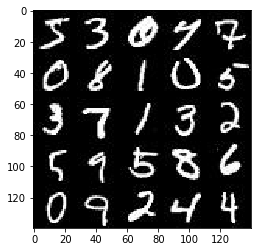

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

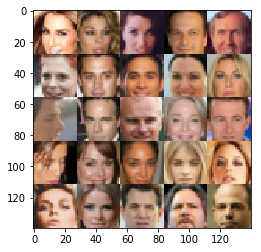

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr_rate = tf.placeholder(tf.float32)
    
    return (inputs_real, inputs_z, lr_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def lrelu(x, alpha=0.2):
    """Leaky ReLu implementation"""
    return tf.maximum(alpha * x, x)

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2
    input_shape = images.get_shape().as_list()[2]
    final_shape = input_shape // 4
    flat_shape = (-1, final_shape * final_shape * 512)
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input as image batch
        net = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        net = tf.maximum(alpha * net, net)
        # First convolution with 64 filters
        
        net = tf.layers.conv2d(net, 128, 5, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = lrelu(net)
        # Second convolution with 128 filters
        
        net = tf.layers.conv2d(net, 512, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = lrelu(net)
        # Second convolution with 512 filters
        
        # Flatten layers
        net = tf.reshape(net, flat_shape)
        logits = tf.layers.dense(net, 1)
        outputs = tf.sigmoid(logits)
        
        
    return (outputs, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # Flat layer
        net = tf.layers.dense(z, 7*7*512)
        net = tf.reshape(net, (-1, 7, 7, 512))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = lrelu(net)
        
        # Deconvolution for 256 filters 14 X 14 shape
        net = tf.layers.conv2d_transpose(net, 256, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = lrelu(net)
        
        # Deconvolution for 128 filters 14 X 14 shape
        net = tf.layers.conv2d_transpose(net, 128, 5, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = lrelu(net)
        
        # Deconvolution for out_channel_dim filters 28 X 28 shape
        net = tf.layers.conv2d_transpose(net, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(net)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    (d_model_real, d_logits_real) = discriminator(input_real)
    (d_model_fake, d_logits_fake) = discriminator(g_model, reuse=True)
    
    # Discriminator loss
    d_labels_real = tf.ones_like(d_model_real)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    d_labels_fake = tf.zeros_like(d_model_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_labels = tf.ones_like(d_model_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    tr_vars = tf.trainable_variables()
    g_vars = [var for var in tr_vars if var.name.startswith('generator')]
    d_vars = [var for var in tr_vars if var.name.startswith('discriminator')]
    
    # I think one could use tf.get_collection((tf.GraphKeys.TRAINABLE_VARIABLES, ...) 
    # but this one (list comprehension) seems more self explanatory
    
    # Training optimizers for appropriated variables
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        genr_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return (disc_train_opt, genr_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = data_shape[3]
    (input_real, input_z, lr_rate) = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    (d_loss, g_loss) = model_loss(input_real, input_z, out_channel_dim)
    (d_opt, g_opt) = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    saver = tf.train.Saver()
    sample_size = 25
    file_prfx = 'celeb_' if data_image_mode == 'RGB' else 'mnist_'
    chkp_file_path = './checkpoints/' + file_prfx + 'generator.ckpt'

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Normalize images
                norm_batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                train_feed_dict = {input_real: norm_batch_images, input_z: batch_z, lr_rate: learning_rate}
                # Run optimizers
                _ = sess.run(d_opt, feed_dict=train_feed_dict)
                _ = sess.run(g_opt, feed_dict=train_feed_dict)
                _ = sess.run(g_opt, feed_dict=train_feed_dict)
                
                if steps % 10 == 0:
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: norm_batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:  
                    # Show samples
                    show_generator_output(sess, sample_size, input_z, out_channel_dim, data_image_mode)
        saver.save(sess, chkp_file_path)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2426... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 2.9865... Generator Loss: 2.1023
Epoch 1/1... Discriminator Loss: 3.5214... Generator Loss: 0.1208
Epoch 1/1... Discriminator Loss: 2.8713... Generator Loss: 0.1996
Epoch 1/1... Discriminator Loss: 2.9988... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 2.6666... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.7345... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 2.1233... Generator Loss: 0.2181
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 2.0999


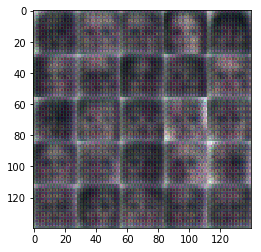

Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 3.8570
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.6905... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 1.5571
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 2.0439
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.4498


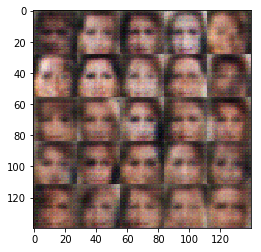

Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 5.6884
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 5.8216
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.9345
Epoch 1/1... Discriminator Loss: 0.2377... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 4.3001
Epoch 1/1... Discriminator Loss: 0.2760... Generator Loss: 4.2564
Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 3.4477
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 6.1073


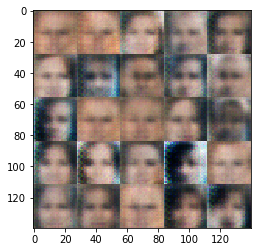

Epoch 1/1... Discriminator Loss: 2.1346... Generator Loss: 0.1869
Epoch 1/1... Discriminator Loss: 0.2123... Generator Loss: 4.4019
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 5.6085
Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.4513
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 4.0390
Epoch 1/1... Discriminator Loss: 3.0803... Generator Loss: 0.0561
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 3.2974
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 2.4469
Epoch 1/1... Discriminator Loss: 0.3225... Generator Loss: 4.7693


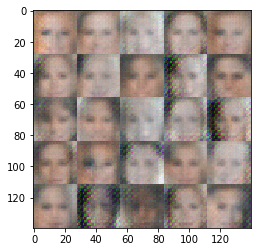

Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 5.1871
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.6601
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 2.6549
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 4.5281
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 9.2796
Epoch 1/1... Discriminator Loss: 0.1499... Generator Loss: 6.6038
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.4073
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 2.0657


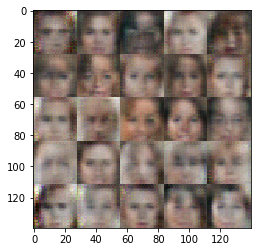

Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 2.0038
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 3.4826
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.2556
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 2.2855


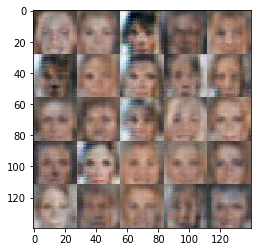

Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.3251... Generator Loss: 1.7803
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 2.9770
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 2.2871... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 1.7928... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7910


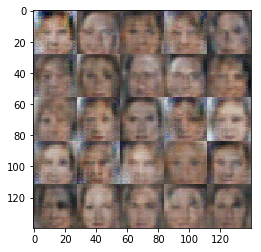

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7787


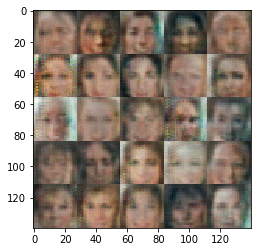

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.7131


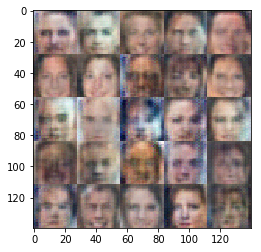

Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.6513... Generator Loss: 0.3167


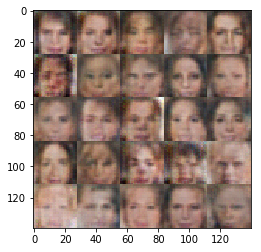

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 3.1024
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6366


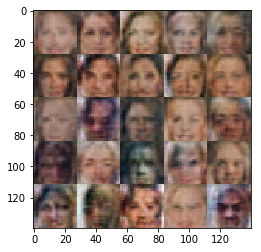

Epoch 1/1... Discriminator Loss: 1.7535... Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.3355
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.2629
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 4.7702
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.0284


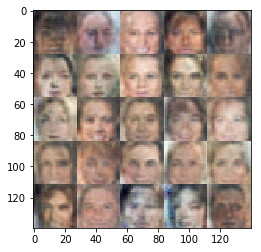

Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 1.9876
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 2.0051
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 1.8238... Generator Loss: 2.8050
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 0.2297
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 2.3780
Epoch 1/1... Discriminator Loss: 1.8459... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.8265... Generator Loss: 0.2512
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 1.6458


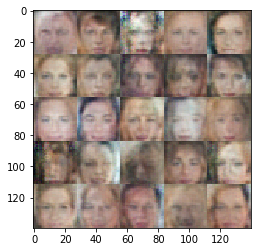

Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 2.4088... Generator Loss: 0.2085
Epoch 1/1... Discriminator Loss: 1.7290... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.8053


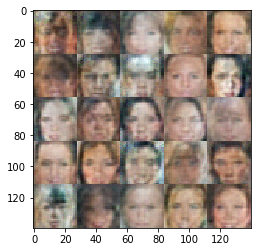

Epoch 1/1... Discriminator Loss: 1.8552... Generator Loss: 0.2211
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 3.0117


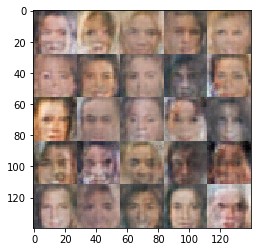

Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 6.7660
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.7727... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6465


In [103]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.